# Sixt Data Science Lab - Test Task for Data Scientist OR + Revenue Management Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your Data Science skills within a Revenue Management context, solving the style of problems you are likely to encounter at Sixt.
Please follow the steps below, building up the necessary code and comment on your choices. We welcome submissions even if you are not able to solve all of the tasks.

## About the data

The data shows expected bookings for rentals in a single branch over a 1 week period. The data considers the different combinations of pickup dates and the length of rent for a vehicle. A 2 day rental with a pickup day of 03/01/2025 would mean the car is rented out for the entirety of 03/01/2025 and 04/01/2025. For each combination you will find the revenue associated with that booking type and a forecast of expected reservations.

For the purposes of this task we will take the following assumptions:
1. Rentals are for only a single car type.
2. All rentals are returned on time and in appropriate condition to be rented out the following day.
3. We do not consider any rentals that extend beyond the week in question.
4. We do not need to consider the uncertainty of the expected reservations forecast.



## Import dependencies

In [1]:
import os
import datetime
import pandas
import matplotlib.pyplot as plt
import numpy
import pulp

## Part 1 - Data Loading and Initial Exploration

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from the attached csv.
3. Visualise the data and comment the distribution of expected reservations and pricing.


Comments on the visualized data:
- The first bar chart shows that the majority of the bookings are expected between 01/01/2025 and 03/01/2025, with a peak on 03/01/2025. No bookings are expected on 06/01/2025.
  Due to the problem assumption that all rentals end within the one-week time horizon, longer rental lengths become increasingly unlikely towards the end of the week.
  -> demand is concentrated in the first half of the week with short-term rentals dominating.

- The aggregated revenue reflects both the number of bookings and the rental duration: longer rentals generate more total revenue.
  -> the highest total revenue is achieved in the first half of the week, in line with the demand pattern analyzed above.

- When normalizing revenue by both the number of vehicles and the number of rental days, it becomes clear that short-term rentals (one to two days) are more profitable.
  Rentals with durations of five to seven days contribute the least revenue per vehicle per day.
  -> sho

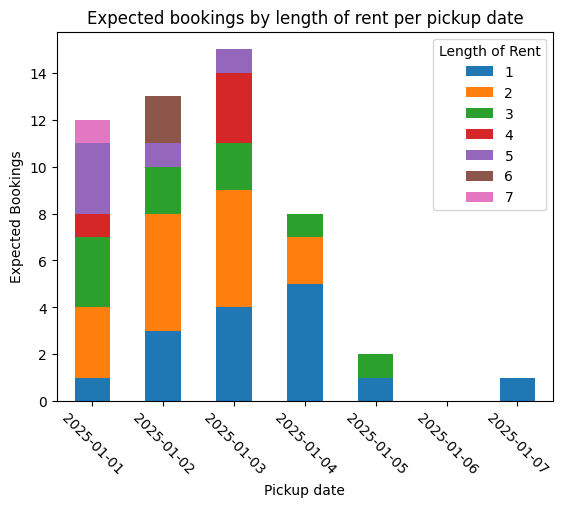

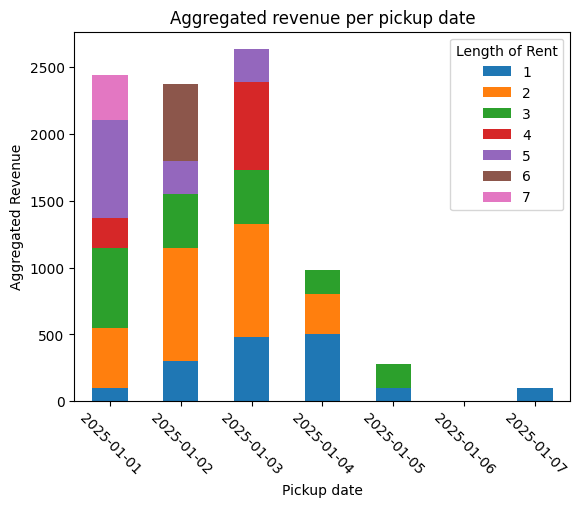

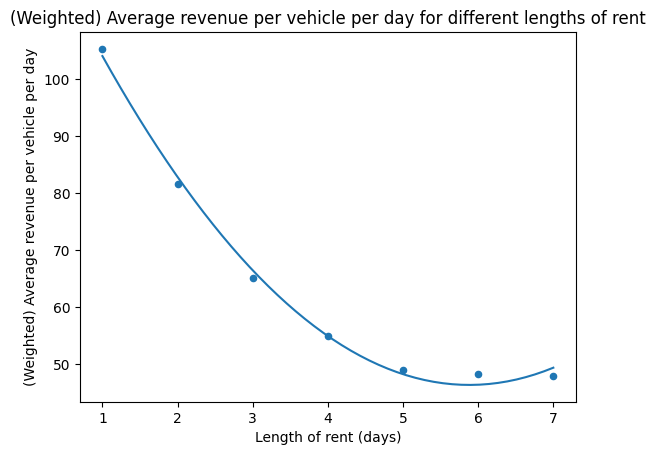

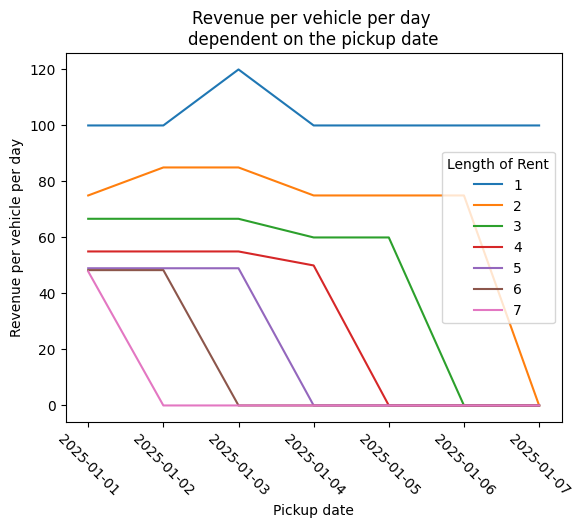

In [2]:
input_file_name = "Sixt_OR_task_data"
input_file_ending = "csv"

input_file_path = os.path.join(".", "{}.{}".format(input_file_name, input_file_ending))
input_file_separator = ","

# --- READ INPUT ---

lines = pandas.read_csv(input_file_path, sep=input_file_separator, parse_dates=["Pickup date"], date_format="%d/%m/%Y").dropna(axis=0, how="all").dropna(axis=1, how="all")
#lines.drop(lines[lines["Expected Bookings"] <= 0].index, inplace=True)
lines["revenue_per_vehicle_per_day"] = lines["Revenue per vehicle"] / lines["Length of Rent"]
lines["Pickup date"] = lines["Pickup date"].dt.date

lines_date_min, lines_date_max = lines["Pickup date"].min(), lines["Pickup date"].max()
lines_data_range = lines_date_max - lines_date_min

total_number_days = lines_data_range.days + 1

# --- VISUALIZE NUMBER OF RESERVATIONS ---

lines["aggregated_revenue"] = lines["Revenue per vehicle"] * lines["Expected Bookings"]

# ---

lines_pivoted = pandas.pivot_table(data=lines, index=['Pickup date'], columns=['Length of Rent'], values='Expected Bookings').fillna(0)
ax = lines_pivoted.plot.bar(stacked=True)

ax.tick_params(axis="x", rotation=-45)
ax.set_xlabel("Pickup date")
ax.set_ylabel("Expected Bookings")

plt.title("Expected bookings by length of rent per pickup date")

# ---

lines_pivoted = pandas.pivot_table(data=lines, index=['Pickup date'], columns=['Length of Rent'], values='aggregated_revenue').fillna(0)
ax = lines_pivoted.plot.bar(stacked=True)

ax.tick_params(axis="x", rotation=-45)
ax.set_xlabel("Pickup date")
ax.set_ylabel("Aggregated Revenue")

plt.title("Aggregated revenue per pickup date")

# --- VISUALIZE WEIGHTED REVENUES ---

def calculate_weighted_average(dataframe):
    if len(dataframe.index) > 0:
        return pandas.Series({"weighted_average_revenue_per_vehicle_per_day": (dataframe["Revenue per vehicle"] * dataframe["Expected Bookings"]).sum() / dataframe["Expected Bookings"].sum() / dataframe["Length of Rent"].iloc[0]})
    else:
        return 0

lines_grouped = lines.groupby(["Length of Rent"])[["Length of Rent", "Revenue per vehicle", "Expected Bookings"]].apply(lambda lines_per_length_of_rent: calculate_weighted_average(lines_per_length_of_rent))
lines_grouped.reset_index(inplace=True)

regression_model = numpy.poly1d(numpy.polyfit(lines_grouped["Length of Rent"], lines_grouped["weighted_average_revenue_per_vehicle_per_day"], 2))
regression_points = numpy.linspace(1, 7)

ax = lines_grouped.plot.scatter(x="Length of Rent", y="weighted_average_revenue_per_vehicle_per_day", xlabel="Length of rent (days)", ylabel="(Weighted) Average revenue per vehicle per day", title="(Weighted) Average revenue per vehicle per day for different lengths of rent")
plt.plot(regression_points, regression_model(regression_points))

# --- VISUALIZE REVENUES PER VEHICLE PER DAY ---

lines_pivoted = pandas.pivot_table(data=lines, index=['Pickup date'], columns=['Length of Rent'], values='revenue_per_vehicle_per_day').reset_index().fillna(0)
ax = lines_pivoted.plot.line(x="Pickup date", y=[number_days for number_days in range(1, total_number_days + 1)], xlabel="Pickup date", ylabel="Revenue per vehicle per day", title="Revenue per vehicle per day \ndependent on the pickup date")
ax.tick_params(axis="x", rotation=-45)


# --- COMMENTS ---

print("Comments on the visualized data:")
print("- The first bar chart shows that the majority of the bookings are expected between 01/01/2025 and 03/01/2025, with a peak on 03/01/2025. No bookings are expected on 06/01/2025.\n"
      "  Due to the problem assumption that all rentals end within the one-week time horizon, longer rental lengths become increasingly unlikely towards the end of the week.\n"
      "  -> demand is concentrated in the first half of the week with short-term rentals dominating.\n")
print("- The aggregated revenue reflects both the number of bookings and the rental duration: longer rentals generate more total revenue.\n"
      "  -> the highest total revenue is achieved in the first half of the week, in line with the demand pattern analyzed above.\n")
print("- When normalizing revenue by both the number of vehicles and the number of rental days, it becomes clear that short-term rentals (one to two days) are more profitable.\n"
      "  Rentals with durations of five to seven days contribute the least revenue per vehicle per day.\n"
      "  -> short-term rentals yield the highest revenue per vehicle per day.\n")
print("- The fourth figure highlights the effect of the rental start on the revenue per vehicle per day.\n"
      "  03/01/2025 offers the highest revenue efficiency for rental durations of one to four days. Other durations cannot be examined due to the week's fixed end.\n"
      "  For some rental durations, starting earlier in the week (e.g., 01/01/2025 or 02/01/2025) results in similarly high revenues.\n"
      "  -> the optimal booking start day in terms of revenue efficiency is in the second quarter of the week.\n")


## Part 2 - Maximal Revenue and Capacities

**Questions:**
1. Suppose we had an unlimited number of cars and were able to service all of the expected demand. What would the total revenue be across the 7 days?
2. How many cars would be rented out on each day?



In [3]:
total_revenue = (lines["Revenue per vehicle"] * lines["Expected Bookings"]).sum()

number_cars_rented_accumulated = [0]*total_number_days
number_cars_rented = [0]*total_number_days

dates = lines["Pickup date"].unique()
dates = dates[dates.argsort()]
date_min = dates.min()

for _, row in lines.iterrows():
    date_index_start = (row["Pickup date"] - date_min).days
    date_index_end = date_index_start + row["Length of Rent"]

    number_cars = row["Expected Bookings"]

    for date_index in range(date_index_start, date_index_end):
        number_cars_rented_accumulated[date_index] += number_cars

    number_cars_rented[date_index_start] += number_cars

# ---

print("{:<2} Given an unlimited number of cars each day, the maximum revenue of this week amounts to {}.".format("1.", total_revenue))
print("")
print("{:<2} The following numbers of cars are rented on the respective days:".format("2."))
for (date_index, number_accumulated) in enumerate(number_cars_rented_accumulated):
    date = dates[date_index]

    print("{:>4} {}: {:>2} cars (of which {:>2} are newly rented that day)".format("-", date, number_accumulated, number_cars_rented[date_index]))

1. Given an unlimited number of cars each day, the maximum revenue of this week amounts to 8810.

2. The following numbers of cars are rented on the respective days:
   - 2025-01-01: 12 cars (of which 12 are newly rented that day)
   - 2025-01-02: 24 cars (of which 13 are newly rented that day)
   - 2025-01-03: 33 cars (of which 15 are newly rented that day)
   - 2025-01-04: 29 cars (of which  8 are newly rented that day)
   - 2025-01-05: 18 cars (of which  2 are newly rented that day)
   - 2025-01-06: 10 cars (of which  0 are newly rented that day)
   - 2025-01-07:  6 cars (of which  1 are newly rented that day)


## Part 3 - Capacity Constraints

For the purpose of this task we can decide which reservations to serve and which to not serve. Any reservations which are not served will appear sold out to the customer. It is possible within this task to serve only part of the expected demand: for example if there are 3 expected reservations for a booking type, to only serve 2 of these customers.



**Questions:**
1. Suppose we only have 10 cars available for the 1st, 6th and 7th, and 20 cars available for the 2nd, 3rd, 4th, 5th. What is the maximum revenue we can obtain with this available fleet and which demand should we choose to serve in order to achieve this revenue.
2. What additional revenue would we get if we had 1 extra car available (21 cars) on 03/01/2025?
3. What if instead, we had 1 additional car available on 04/01/2025?
4. What if we had 1 additional car available on both 03/01/2025 and 04/01/2025?



In [4]:
problem = pulp.LpProblem("Optimize_bookings", pulp.LpMaximize)

booking_types = [length_rent for length_rent in range(1, total_number_days + 1)]
pickup_dates = [date for date in dates]
expected_revenue = {(line["Pickup date"], line["Length of Rent"]): line["Revenue per vehicle"] for _, line in lines.iterrows()}
capacities_baseline = [10]*total_number_days
capacities_extension = [0, 10, 10, 10, 10, 0, 0]

# --- variables ---
variables_number_bookings_upper_bounds = {(line["Pickup date"], line["Length of Rent"]): line["Expected Bookings"] for _, line in lines.iterrows()}

variables_number_bookings = {}
for length_rent in booking_types:
    for date in pickup_dates:
        if (date, length_rent) in variables_number_bookings_upper_bounds:
            variables_number_bookings[(date, length_rent)] = pulp.LpVariable("number_bookings_{}_{}".format(date, length_rent), lowBound=0, upBound=variables_number_bookings_upper_bounds[date, length_rent], cat='Continuous')

# --- objective function ---
problem += pulp.lpSum([expected_revenue[date, length_rent] * variables_number_bookings[date, length_rent] for date in pickup_dates for length_rent in booking_types if (date, length_rent) in variables_number_bookings_upper_bounds])

# --- capacity constraints ---
for d, date in enumerate(pickup_dates):
    problem += (pulp.lpSum([variables_number_bookings[(pickup_dates[d_before], length_rent)] for length_rent in booking_types for d_before in range(0, d + 1) if d_before + (length_rent - 1) >= d and (pickup_dates[d_before], length_rent) in variables_number_bookings_upper_bounds]) <= [capacities_baseline[d] + capacities_extension[d]], "capacity_on_{}".format(date))

problem.solve()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

total_revenue_baseline = pulp.value(problem.objective)

print("{:<2} Given a limited number of cars on each day, the maximum revenue of this week amounts to {} ({}).".format("1.", pulp.value(problem.objective), pulp.LpStatus[problem.status]))
print("The following bookings including their amount should be accepted:")

solution = {}
for length_rent in booking_types:
    for date in pickup_dates:
        if (date, length_rent) in variables_number_bookings_upper_bounds:
            variable = variables_number_bookings[(date, length_rent)]

            if int(variable.varValue) > 0:
                solution.update({(date, length_rent): int(variable.varValue)})

solution_dataframe = pandas.DataFrame.from_dict(solution, orient='index')
solution_dataframe.sort_index(inplace=True)

for (date, length_rent), number in solution_dataframe.iterrows():
    print("{:>4} {:>2} bookings on {} having a duration of {:>2} day(s)".format("-", number[0], date.strftime('%d/%m/%Y'), length_rent))

print("")

# for name, constraint in problem.constraints.items():
#     print("{} {}".format(name, constraint.pi))
#     for variable in constraint.expr:
#         print("{} {}/{} {}".format(variable.name, int(variable.varValue), variable.upBound, variable.dj))


def calculate_dual_price(date_string):
    if -1e-4 < problem.constraints["capacity_on_{}".format(date_string).replace(" ", "_").replace("-", "_")].pi < 1e-4:
        return 0

    # ---

    index_date = pickup_dates.index(datetime.datetime.strptime(date_string, '%Y-%m-%d').date())

    index_start = index_date
    index_end = index_date

    for index in range(index_date - 1, -1, -1):
        if  -1e-4 < problem.constraints["capacity_on_{}".format(str(dates[index])).replace(" ", "_").replace("-", "_")].pi < 1e-4:
            index_start = index
        else:
            break

    for index in range(index_date + 1, len(dates)):
        if -1e-4 < problem.constraints["capacity_on_{}".format(str(dates[index])).replace(" ", "_").replace("-", "_")].pi < 1e-4:
            index_end = index
        else:
            break

    revenue_maximum = 0

    for index_date in range(index_start, index_end + 1):
        for length_rent in booking_types:
            if index_date + length_rent - 1 <= index_end:
                if (pickup_dates[index_date], length_rent) in variables_number_bookings_upper_bounds:
                    variable_dual_price = variables_number_bookings[(pickup_dates[index_date], length_rent)]

                    if int(variable_dual_price.varValue) < variable_dual_price.upBound and expected_revenue[pickup_dates[index_date], length_rent] > revenue_maximum:
                        revenue_maximum = expected_revenue[pickup_dates[index_date], length_rent]

    # ---

    if revenue_maximum == 0:
        problem.constraints["capacity_on_{}".format(date_string).replace(" ", "_").replace("-", "_")].constant += -1

        problem.solve()

        revenue_maximum = int(pulp.value(problem.objective) - total_revenue_baseline)

        # --- reset ---

        problem.constraints["capacity_on_{}".format(date_string).replace(" ", "_").replace("-", "_")].constant -= -1

    # ---

    return revenue_maximum

print("{:>2} If we consider an additional car on January 3rd, 2025, we can increase the revenue by {}.".format("2.", calculate_dual_price("2025-01-03")))
print("")
print("{:>2} If we consider an additional car on January 4th, 2025, we can increase the revenue by {}.".format("3.", calculate_dual_price("2025-01-04")))

# ---
problem.constraints["capacity_on_2025_01_03"].constant += -1
problem.constraints["capacity_on_2025_01_04"].constant += -1

problem.solve()

print("")
print("{:<2} If we consider an additional car both on January 3rd, 2025, and on January 4th, 2025, we can increase the revenue by {}.".format("4.", pulp.value(problem.objective) - total_revenue_baseline))

1. Given a limited number of cars on each day, the maximum revenue of this week amounts to 6615.0 (Optimal).
The following bookings including their amount should be accepted:
   -  1 bookings on 01/01/2025 having a duration of  1 day(s)
   -  3 bookings on 01/01/2025 having a duration of  2 day(s)
   -  3 bookings on 01/01/2025 having a duration of  3 day(s)
   -  2 bookings on 01/01/2025 having a duration of  5 day(s)
   -  1 bookings on 01/01/2025 having a duration of  7 day(s)
   -  3 bookings on 02/01/2025 having a duration of  1 day(s)
   -  5 bookings on 02/01/2025 having a duration of  2 day(s)
   -  1 bookings on 02/01/2025 having a duration of  5 day(s)
   -  2 bookings on 02/01/2025 having a duration of  6 day(s)
   -  2 bookings on 03/01/2025 having a duration of  3 day(s)
   -  3 bookings on 03/01/2025 having a duration of  4 day(s)
   -  1 bookings on 03/01/2025 having a duration of  5 day(s)
   -  5 bookings on 04/01/2025 having a duration of  1 day(s)
   -  2 bookings on

## Part 4 - Optimizing fleet selection

Consider the following fleet costs.

Each vehicle that is added to the fleet costs us a flat fee of 100 euros and then an additional 20 euros for each day. For example, if we choose to have 10 vehicles on day 1 and 20 vehicles on day 2, there would be 10 vehicles with a cost of 140 euros (on day 1 and 2) and an additional 10 vehicles with a cost of 120 euros (on day 2 only). We can assume there to be no other additional costs of renting out the vehicle. Cars can be added or removed from the available fleet on any given day.

**Questions:**
1. Given these fleet costs, what would the profit maximising fleet be for this week? What total profit would be expected?

In [5]:
problem_extended = pulp.LpProblem("Optimize_bookings_with_vehicle_cost", pulp.LpMaximize)

booking_types = [length_rent for length_rent in range(1, total_number_days + 1)]
pickup_dates = [date for date in dates]
expected_revenue = {(line["Pickup date"], line["Length of Rent"]): line["Revenue per vehicle"] for _, line in lines.iterrows()}

# --- variables ---
variables_number_bookings_upper_bounds = {(line["Pickup date"], line["Length of Rent"]): line["Expected Bookings"] for _, line in lines.iterrows()}

variables_number_bookings = {}
for length_rent in booking_types:
    for date in pickup_dates:
        if (date, length_rent) in variables_number_bookings_upper_bounds:
            variables_number_bookings[(date, length_rent)] = pulp.LpVariable("number_bookings_{}_{}".format(date, length_rent), lowBound=0, upBound=variables_number_bookings_upper_bounds[date, length_rent], cat='Continuous')

variables_number_vehicles = {}
for length_rent in booking_types:
    for date in pickup_dates:
        if (date, length_rent) in variables_number_bookings_upper_bounds:
            variables_number_vehicles[(date, length_rent)] = pulp.LpVariable("number_vehicles_{}_{}".format(date, length_rent), lowBound=0, cat='Continuous')

# --- objective function ---
fixed_cost = 100
variable_cost = 20

problem_extended += pulp.lpSum([expected_revenue[date, length_rent] * variables_number_bookings[date, length_rent] - (fixed_cost + variable_cost * length_rent) * variables_number_vehicles[date, length_rent] for date in pickup_dates for length_rent in booking_types if (date, length_rent) in variables_number_bookings_upper_bounds])

# --- capacity constraints ---
for d, date in enumerate(pickup_dates):
    problem_extended += \
        (pulp.lpSum([variables_number_bookings[(pickup_dates[d_before], length_rent)] for length_rent in booking_types for d_before in range(0, d + 1) if d_before + (length_rent - 1) >= d and (pickup_dates[d_before], length_rent) in variables_number_bookings_upper_bounds])
         <=
         [pulp.lpSum([variables_number_vehicles[(pickup_dates[d_before], length_rent)] for length_rent in booking_types for d_before in range(0, d + 1) if d_before + (length_rent - 1) >= d and (pickup_dates[d_before], length_rent) in variables_number_bookings_upper_bounds]) ], "capacity_on_{}".format(date))

problem_extended.solve()

# ---

total_revenue_baseline = pulp.value(problem_extended.objective)

print("{:<2} Assuming a variable number of cars is available each day and each car incurs fixed and variable cost, the maximum revenue of this week amounts to {} ({}).".format("1.", pulp.value(problem_extended.objective), pulp.LpStatus[problem_extended.status]))
print("The following fleet composition is recommended:")

solution_extended = {}
for length_rent in booking_types:
    for date in pickup_dates:
        if (date, length_rent) in variables_number_bookings_upper_bounds:
            variable = variables_number_vehicles[(date, length_rent)]

            if int(variable.varValue) > 0:
                solution_extended.update({(date, length_rent): int(variable.varValue)})

solution_extended_dataframe = pandas.DataFrame.from_dict(solution_extended, orient='index')
solution_extended_dataframe.sort_index(inplace=True)

for (date, length_rent), number in solution_extended_dataframe.iterrows():
    print("{:>4} On {}, {:>2} vehicles are selected, each with an availability of {:<2} day(s)".format("-", date.strftime('%d/%m/%Y'), number[0], length_rent))

print("")

print("Overview of the total number of vehicles per day:")
for date in pickup_dates:
    constraint = problem_extended.constraints["capacity_on_{}".format(date).replace(" ", "_").replace("-", "_")]

    total_number_vehicles_per_day = 0

    for variable in constraint.expr:
        if "number_vehicles" in variable.name:
            total_number_vehicles_per_day += int(variable.varValue)

    print("{:>4} {}: {:>2} vehicles".format("-", date.strftime('%d/%m/%Y'), total_number_vehicles_per_day))

1. Assuming a variable number of cars is available each day and each car incurs fixed and variable cost, the maximum revenue of this week amounts to 2870.0 (Optimal).
The following fleet composition is recommended:
   - On 01/01/2025,  2 vehicles are selected, each with an availability of 4  day(s)
   - On 01/01/2025,  4 vehicles are selected, each with an availability of 6  day(s)
   - On 01/01/2025,  6 vehicles are selected, each with an availability of 7  day(s)
   - On 02/01/2025,  4 vehicles are selected, each with an availability of 2  day(s)
   - On 02/01/2025,  8 vehicles are selected, each with an availability of 4  day(s)
   - On 03/01/2025,  9 vehicles are selected, each with an availability of 2  day(s)

Overview of the total number of vehicles per day:
   - 01/01/2025: 12 vehicles
   - 02/01/2025: 24 vehicles
   - 03/01/2025: 33 vehicles
   - 04/01/2025: 29 vehicles
   - 05/01/2025: 18 vehicles
   - 06/01/2025: 10 vehicles
   - 07/01/2025:  6 vehicles


## Part 5 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

In [6]:
print("I really appreciated the practical nature of the task – it was engaging and well-structured.")
print("One small point of feedback: for the visualization part, a brief clarification of the intended audience or use case would have helped align expectations. In a real-world project, I would actively ask this early on to ensure the figures fit the need.")

I really appreciated the practical nature of the task – it was engaging and well-structured.
One small point of feedback: for the visualization part, a brief clarification of the intended audience or use case would have helped align expectations. In a real-world project, I would actively ask this early on to ensure the figures fit the need.


## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.